# Debugging
* LangGraph supports debugging by viewing, re-playing, and even forking from past states.
* **The LangGraph team sometimes calls these techniques "time travel"**, since what they do is to allow you to run the app starting from a chosen step.

## Setup

#### After you download the code from the github repository in your computer
In terminal:
* cd project_name
* pyenv local 3.11.4
* poetry install
* poetry shell

#### To open the notebook with Jupyter Notebooks
In terminal:
* jupyter lab

Go to the folder of notebooks and open the right notebook.

#### To see the code in Virtual Studio Code or your editor of choice.
* open Virtual Studio Code or your editor of choice.
* open the project-folder
* open the 019-debugging.py file

## Create your .env file
* In the github repo we have included a file named .env.example
* Rename that file to .env file and here is where you will add your confidential api keys. Remember to include:
* OPENAI_API_KEY=your_openai_api_key
* LANGCHAIN_TRACING_V2=true
* LANGCHAIN_ENDPOINT=https://api.smith.langchain.com
* LANGCHAIN_API_KEY=your_langchain_api_key
* LANGCHAIN_PROJECT=your_project_name

## Track operations
From now on, we can track the operations **and the cost** of this project from LangSmith:
* [smith.langchain.com](https://smith.langchain.com)

## Connect with the .env file located in the same directory of this notebook

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [1]:
#pip install python-dotenv

In [1]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())
openai_api_key = os.environ["OPENAI_API_KEY"]
os.environ["http_proxy"] = ""
os.environ["https_proxy"] = ""

#### Install LangChain

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [3]:
#!pip install langchain

## Connect with an LLM

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [4]:
#!pip install langchain-openai

In [2]:
from langchain_openai import ChatOpenAI

chatModel35 = ChatOpenAI(model="gpt-3.5-turbo-0125")
chatModel4o = ChatOpenAI(model="gpt-4o")

## Initial app

In [3]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

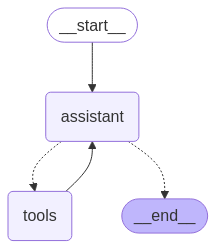

In [4]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()

graph = builder.compile(checkpointer=MemorySaver())

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [5]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_KAbBbJbelVgFS20v4KgztnqC)
 Call ID: call_KAbBbJbelVgFS20v4KgztnqC
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


## Using get_state to look at the current state and thread of the app
* **graph.get_state()** provides the most recent step.
* We can use get_state to look at the current state of our app, given the thread_id:

In [6]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='bcd6c2b4-c3df-498f-9149-a9cdda9f645c'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KAbBbJbelVgFS20v4KgztnqC', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 131, 'total_tokens': 149, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_90d33c15d4', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-82104a6b-e1b1-451c-b24d-4ceb6fd41e6f-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_KAbBbJbelVgFS20v4KgztnqC', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1

## Here’s a more readable version of the previous response

#### State  
**Messages**:  
1. **User Message**  
   - **Content**: "Multiply 2 and 3"  
   - **ID**: `4ee8c440-0e4a-47d7-852f-06e2a6c4f84d`  

2. **AI Message** (Initial response)  
   - **Content**: *(Empty)*  
   - **Tool Call**:  
     - **ID**: `call_ikJxMpb777bKMYgmM3d9mYjW`  
     - **Function**:  
       - **Name**: `multiply`  
       - **Arguments**: `{"a": 2, "b": 3}`  
     - **Type**: `function`  
   - **Metadata**:  
     - **Tokens Used**:  
       - Completion: 17  
       - Prompt: 131  
       - Total: 148  
     - **Model**: `gpt-4o-2024-05-13`  
     - **Finish Reason**: `tool_calls`  
   - **ID**: `run-bc24d334-8013-4f85-826f-e1ed69c86df0-0`  

3. **Tool Message** (Tool Response)  
   - **Content**: `6`  
   - **Tool Name**: `multiply`  
   - **ID**: `1012611a-30c5-4732-b789-8c455580c7b4`  
   - **Tool Call ID**: `call_ikJxMpb777bKMYgmM3d9mYjW`  

4. **AI Message** (Final Output)  
   - **Content**: "The result of multiplying 2 and 3 is 6."  
   - **Metadata**:  
     - **Tokens Used**:  
       - Completion: 14  
       - Prompt: 156  
       - Total: 170  
     - **Model**: `gpt-4o-2024-05-13`  
     - **Finish Reason**: `stop`  
   - **ID**: `run-b46f3fed-ca3b-4e09-83f4-77ea5071e9bf-0`  

#### Next Steps  
- **Next**: *(Empty)*  


#### Configuration  
- **Thread ID**: `1`  
- **Checkpoint ID**: `1ef6a440-ac9e-6024-8003-6fd8435c1d3b`  


#### Metadata  
- **Source**: `loop`  
- **Writes**:  
  - Assistant Message: "The result of multiplying 2 and 3 is 6."  
- **Step**: `3`  


#### Creation Details  
- **Timestamp**: `2024-09-03T22:29:54.309727+00:00`  


#### Parent Configuration  
- **Checkpoint ID**: `1ef6a440-a759-6d02-8002-f1da6393e1ab`

## We can now use **get_state_history** to get the state at all prior steps:
* **graph.get_state_history()** provides list of all steps.

In [7]:
all_states = [s for s in graph.get_state_history(thread)]

len(all_states)

5

## Let's display the state in one particular step of the app workflow
* We will do this to debug it, when the app is not working well in that particular step.

In [8]:
all_states[-2]

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='bcd6c2b4-c3df-498f-9149-a9cdda9f645c')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f008d0f-9378-6ad8-8000-19bf2a734b44'}}, metadata={'source': 'loop', 'writes': None, 'thread_id': '1', 'step': 0, 'parents': {}}, created_at='2025-03-24T16:56:47.587190+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f008d0f-9374-63a2-bfff-a579f25481d4'}}, tasks=(PregelTask(id='c5cf33f3-710d-7e5b-b135-ed20f399c618', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KAbBbJbelVgFS20v4KgztnqC', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_t

## Here is a more readable format of the previous response

#### State  

**Messages**:  
1. **User Message**  
   - **Content**: "Multiply 2 and 3"  
   - **ID**: `6962373e-91bd-41cb-8cdf-f8a646b024ef`  
   - **Additional Data**: *(None)*  

#### Next Steps:  
- **Next**: `assistant`  

#### Configuration:  
- **Thread ID**: `1`  
- **Checkpoint ID**: `1efbb93b-56d0-6f56-8000-babbdc48f6e3`  

#### Metadata:  
- **Source**: `loop`  
- **Writes**: *(None)*  
- **Thread ID**: `1`  
- **Step**: `0`  

#### Creation Details:  
- **Timestamp**: `2024-12-16T09:54:15.018467+00:00`  

#### Parent Configuration:  
- **Checkpoint ID**: `1efbb93b-56c8-6194-bfff-94fdcd886b5f`  

#### Tasks:  

**Task Information**  
- **Task ID**: `bea2ad80-4a1b-dca8-9a54-345a75929c17`  
- **Name**: `assistant`  
- **Path**: `('__pregel_pull', 'assistant')`  
- **State**: *(None)*  

#### Task Result:  

**AI Message** (Initial Response)  
- **Content**: *(Empty)*  
- **Tool Calls**:  
  1. **Tool Call ID**: `call_MSecnS0bCms5CM8Q7YqpUmhV`  
     - **Function**:  
       - **Name**: `multiply`  
       - **Arguments**: `{"a": 2, "b": 3}`  
     - **Type**: `function`  

#### Metadata for AI Message:  
- **Tokens Used**:  
  - Completion: 17  
  - Prompt: 131  
  - Total: 148  
- **Model**: `gpt-4o-2024-08-06`  
- **Finish Reason**: `tool_calls`  

#### Usage Metadata:  
- **Input Tokens**: 131  
- **Output Tokens**: 17  
- **Total Tokens**: 148  

**Token Details**:  
- **Input**:  
  - Audio: 0  
  - Cache Read: 0  
- **Output**:  
  - Audio: 0  
  - Reasoning: 0  


## Here’s what the previous code does, broken down step by step:

1. **`graph.get_state_history(thread)`**:
   - This function is part of the LangGraph library. 
   - It retrieves the history of states for a particular `thread`.

2. **`[s for s in graph.get_state_history(thread)]`**:
   - This is a **list comprehension**. It iterates over each state in the state history returned by `graph.get_state_history(thread)` and creates a list of all those states.
   - The resulting list, `all_states`, contains all the states the thread has been in, in chronological order.

3. **`len(all_states)`**:
   - This calculates the total number of states in `all_states`, i.e., the number of states the thread has transitioned through.

4. **`all_states[-2]`**:
   - This accesses the second-to-last state in the list. In Python, negative indexing allows you to count from the end of a list, where `-1` is the last item, `-2` is the second-to-last, and so on.
   - `all_states[-2]` retrieves the penultimate state in the thread’s history.

## How to re-play one particular step so we can debug it.

In [9]:
step_to_replay = all_states[-2]

step_to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f008d0f-9378-6ad8-8000-19bf2a734b44'}}

In [10]:
step_to_replay.next

('assistant',)

#### To replay from here, we simply pass the config back to the agent.
* The graph knows that this step (aka checkpoint) has aleady been executed.
* It just re-plays from this step (aka checkpoint).
* In other words, **graph.stream(None, {particular_step, thread_id})** executes graph from the particular_step:

In [11]:
for event in graph.stream(None, step_to_replay.config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_FeH4RMy4J5xUm9u5HAuMGeXf)
 Call ID: call_FeH4RMy4J5xUm9u5HAuMGeXf
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


## Let's clarify the concepts we have been using
* As it usually happens with almost every document produced by the LangChain team, the LangGraph documentation is confusing and difficult to understand if we do not clarify it first. Let's clarify now the concepts we have been using in this lecture:

#### What is a step in LangGraph?
* **step**:
    * Normally, each node is a separate step.
    * If we have parallel nodes in the app, the parallel nodes run in the same step.
    * PAY ATTENTION: Frequently, the LangGraph team uses the words "checkpoint" and "step" as synonimous.

#### How can we see what is in the state of an app in LangGraph?
* **graph.get_state()** provides the most recent step.
* **graph.get_state_history()** provides a list of all the steps.

#### How can we execute an app starting from different steps in LangGraph?
* **graph.stream(None, {thread_id})** executes graph from the most recent step.
* **graph.stream(None, {particular_step, thread_id})** executes graph from the particular_step.

## Forking
* **In our debugging process, sometimes we will want to run the app from the same step but with a different input** in order to see how the app behaves with the new input. This is called forking.

## First, let's select the step we want to fork

In [13]:
step_to_fork = all_states[-2]
step_to_fork.values["messages"]

[HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='bcd6c2b4-c3df-498f-9149-a9cdda9f645c')]

In [14]:
step_to_fork.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f008d0f-9378-6ad8-8000-19bf2a734b44'}}

## Now, let's enter a new input for the forked step
#### To do it, we will run update_state with the checkpoint_id associated with the forked step.
* Remember how our reducer on messages works:
    * It will append, unless we supply a message ID.
    * We supply the message ID to overwrite the message, rather than appending to state.
* **To overwrite the the message we have to supply the message ID**, which we have in step_to_fork.values["messages"][0].id

In [15]:
# PAY ATTENTION: see how we enter the different input for the forked step
# Now the new input for the same step will be "Multiply 5 and 100"
# Instead of the previous input "Multiply 2 and 3"
fork_config = graph.update_state(
    step_to_fork.config,
    {"messages": [HumanMessage(content='Multiply 5 and 100', 
                               id=step_to_fork.values["messages"][0].id)]},
)

fork_config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f008d18-e277-6978-8001-9df11e53b54f'}}

* **This creates a new forked step with this different input**, but the metadata of the step - e.g., where to go next - is preserved.
* We can see that now the current state of the agent has been updated with our fork:

In [16]:
all_states = [state for state in graph.get_state_history(thread) ]
all_states[0].values["messages"]

[HumanMessage(content='Multiply 5 and 100', additional_kwargs={}, response_metadata={}, id='bcd6c2b4-c3df-498f-9149-a9cdda9f645c')]

In [17]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 100', additional_kwargs={}, response_metadata={}, id='bcd6c2b4-c3df-498f-9149-a9cdda9f645c')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f008d18-e277-6978-8001-9df11e53b54f'}}, metadata={'source': 'update', 'writes': {'__start__': {'messages': [HumanMessage(content='Multiply 5 and 100', additional_kwargs={}, response_metadata={}, id='bcd6c2b4-c3df-498f-9149-a9cdda9f645c')]}}, 'thread_id': '1', 'step': 1, 'parents': {}, 'checkpoint_ns': '', 'checkpoint_id': '1f008d0f-9378-6ad8-8000-19bf2a734b44'}, created_at='2025-03-24T17:00:57.462406+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f008d0f-9378-6ad8-8000-19bf2a734b44'}}, tasks=(PregelTask(id='73cf7d9a-875b-7272-0053-d9ded0795900', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),))

## Finally, let's run the forked step with the new input

* When we now run the app with stream, the app knows that the forked step has never been executed. So, the app runs this new step instead of replaying it.
* Here, we will use **graph.stream()** to run the app from the forked step. As you see, the forked step with the new input is identified by fork_config:

In [18]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 5 and 100
================================== Ai Message ==================================
Tool Calls:
  multiply (call_IHbooFO8Orvf5zXhPUTuOr3d)
 Call ID: call_IHbooFO8Orvf5zXhPUTuOr3d
  Args:
    a: 5
    b: 100
================================= Tool Message =================================
Name: multiply

500
================================== Ai Message ==================================

The result of multiplying 5 and 100 is 500.


* **Regarding stream_mode="values"**, remember that as we saw in a previous lecture, LangGraph supports different streaming modes for graph state:
    * stream_mode="updates": This streams only the updates to the state after each node is called.
    * stream_mode="values": This streams the full state after each node is called.

![Simple graph](graph004.png)

## Finally, print the current state of the app
* You will see that now the current state is the result of running the forked step:

In [19]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 100', additional_kwargs={}, response_metadata={}, id='bcd6c2b4-c3df-498f-9149-a9cdda9f645c'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_IHbooFO8Orvf5zXhPUTuOr3d', 'function': {'arguments': '{"a":5,"b":100}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 131, 'total_tokens': 149, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_90d33c15d4', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4660dc2a-4edc-4d28-b585-0e8e6aa44c42-0', tool_calls=[{'name': 'multiply', 'args': {'a': 5, 'b': 100}, 'id': 'call_IHbooFO8Orvf5zXhPUTuOr3d', 'type': 'tool_call'}], usage_metadata={'input_toke

## Here is a more readable format of the previous response

#### State  

**Messages**:  
1. **User Message**  
   - **Content**: "Multiply 5 and 100"  
   - **ID**: `6962373e-91bd-41cb-8cdf-f8a646b024ef`  

2. **AI Message** (Initial Response)  
   - **Content**: *(Empty)*  
   - **Tool Call**:  
     - **ID**: `call_KfsUs9Q0R1SNREjUDY4CIdA0`  
     - **Function**:  
       - **Name**: `multiply`  
       - **Arguments**: `{"a": 5, "b": 100}`  
     - **Type**: `function`  
   - **Metadata**:  
     - **Tokens Used**:  
       - Completion: 17  
       - Prompt: 131  
       - Total: 148  
     - **Model**: `gpt-4o-2024-08-06`  
     - **Finish Reason**: `tool_calls`  
   - **ID**: `run-fd5914b6-2f59-492d-b836-1da28f65df92-0`  

3. **Tool Message** (Tool Response)  
   - **Content**: `500`  
   - **Tool Name**: `multiply`  
   - **ID**: `210e31ea-1b9a-40a8-923d-c3f79efd1b1f`  
   - **Tool Call ID**: `call_KfsUs9Q0R1SNREjUDY4CIdA0`  

4. **AI Message** (Final Output)  
   - **Content**: "The result of multiplying 5 and 100 is 500."  
   - **Metadata**:  
     - **Tokens Used**:  
       - Completion: 14  
       - Prompt: 156  
       - Total: 170  
     - **Model**: `gpt-4o-2024-08-06`  
     - **Finish Reason**: `stop`  
   - **ID**: `run-92ee4d35-0e08-421f-a123-5358626c4957-0`  

#### Next Steps:  
- **Next**: *(Empty)*  

#### Configuration:  
- **Thread ID**: `1`  
- **Checkpoint ID**: `1efbb9a4-14a2-68d2-8004-87587ff92dfc`  

#### Metadata:  
- **Source**: `loop`  
- **Writes**:  
  - Assistant Message: "The result of multiplying 5 and 100 is 500."  
- **Step**: `4`  

#### Creation Details:  
- **Timestamp**: `2024-12-16T10:41:06.651107+00:00`  

#### Parent Configuration:  
- **Checkpoint ID**: `1efbb9a4-082d-6250-8003-f0a795f0667b`  

#### Usage Metadata:  
- **Input Tokens**: 156  
- **Output Tokens**: 14  
- **Total Tokens**: 170  

**Token Details**:  
- **Input**:  
  - Audio: 0  
  - Cache Read: 0  
- **Output**:  
  - Audio: 0  
  - Reasoning: 0  

## How to execute the code from Visual Studio Code
* In Visual Studio Code, see the file 019-debugging.py
* In terminal, make sure you are in the directory of the file and run:
    * python 019-debugging.py
    * Remember to add print statements in the code when necessary.